In [1]:
import json
import os 
import random
from collections import Counter, defaultdict
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [2]:
dataset = "flickr8k" # "flickr30k

2
6000
30000
<start>amanrockclimbing<end>
<start>ashirtlesspersonwithjeansisclimbingarockymountainside<end>
<start>extremerockwallclimbing<end>
<start>amanclimbingtherockyfaceofamountain<end>
<start>aclimberonsomerocks<end>


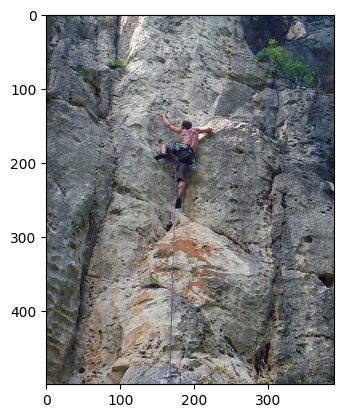

In [3]:
# 加载词汇表文件
with open(f'/kaggle/input/myflickr8k/vocab.json','r') as f:
    vocab = json.load(f)

# 将词汇表从词到索引的映射转换为索引到词的映射
vocab_idx2word = {idx: word for word, idx in vocab.items()}
 
# 加载测试数据集文件
with open(f'/kaggle/input/myflickr8k/train_data.json','r') as f:
    data = json.load(f)

# 从测试数据集中选择一张图片（第301张图片，因为索引从0开始）并显示
content_img = Image.open(data['IMAGES'][300])
plt.imshow(content_img)
# 打印数据集的基本信息
print(len(data))  # 打印data字典中键的数量，通常应该是2（'IMAGES' 和 'CAPTIONS'）
print(len(data['IMAGES']))  # 打印测试集中图片的总数
print(len(data["CAPTIONS"]))  # 打印测试集中文本描述的总数
 
# 对于选定的图片，打印其所有（5个）对应的文本描述
for i in range(5):
    # 计算当前图片对应的第i个描述的索引（每张图片有5个描述）
    word_indeces = data['CAPTIONS'][300*5+i]
    # 将文本描述的索引列表转换为单词列表，并连接成字符串打印出来
    print(''.join([vocab_idx2word[idx] for idx in word_indeces]))

In [4]:
class ImageTextDataset(Dataset):
    """
    PyTorch 数据集类，用于从指定的数据集中加载图像和对应的文本描述。
    可以配合 PyTorch DataLoader 使用，以便在模型训练或评估时按批次产生数据。
    """
    def __init__(self, dataset_path, vocab_path, split, captions_per_image=5, max_len=30, transform=None):
        """
        初始化 ImageTextDataset 实例。

        参数：
            dataset_path (str): JSON 格式数据文件的路径，该文件包含图像路径和对应的文本描述。
            vocab_path (str): JSON 格式字典文件的路径，该文件包含数据集中单词到索引的映射。
            split (str): 数据集的哪一部分将被加载，可选值为 "train", "val", "test"。
            captions_per_image (int): 每张图片对应的文本描述数量，默认为5。
            max_len (int): 文本描述中允许的最大单词数量，默认为30。
            transform (callable, optional): 一个函数或变换，用于对每张图像进行预处理。如果为None，则不应用任何预处理。

        注意：
            - 数据文件和词典文件应该是JSON格式，并且具有特定的结构。
            - 数据文件应包含两个键："IMAGES" 和 "CAPTIONS"，分别对应图像路径列表和文本描述列表。
            - 词典文件应包含单词到索引的映射。
        """
        self.split = split
        assert self.split in {"train", "val", "test"}, "split 参数必须是 'train', 'val', 或 'test' 其中之一。"
        self.cpi = captions_per_image
        self.max_len = max_len
 
        # 加载图像和文本描述数据
        with open(dataset_path, "r") as f:
            self.data = json.load(f)
        
        # 加载词典
        with open(vocab_path, "r") as f:
            self.vocab = json.load(f)
        
        # 设置图像预处理流程
        self.transform = transform
 
        # 计算数据集大小（即文本描述的总数量）
        self.dataset_size = len(self.data["CAPTIONS"])
    
    def __getitem__(self, i):
        """
        获取第 i 个数据点。

        参数：
            i (int): 数据点的索引。

        返回：
            tuple: 包含三个元素的元组 (img, caption, caplen)。
                - img (Tensor): 经过预处理的图像。
                - caption (Tensor): 对应的文本描述，已转换为单词索引的序列，并进行了适当的填充。
                - caplen (int): 原始文本描述的长度（不包括填充）。
        """
        # 计算对应的图像索引，并加载图像
        img = Image.open(self.data['IMAGES'][i // self.cpi]).convert("RGB")
        
        # 如果设置了图像预处理，则应用之
        if self.transform is not None:
            img = self.transform(img)
        
        # 获取文本描述的实际长度，并根据最大长度进行填充
        caplen = len(self.data["CAPTIONS"][i])
        pad_caps = [self.vocab['<pad>']] * (self.max_len + 2 - caplen)  # 注意填充以达到 max_len + 2
        caption = torch.LongTensor(self.data["CAPTIONS"][i] + pad_caps)
 
        return img, caption, caplen
 
    def __len__(self):
        """
        获取数据集中数据点的总数。

        返回：
            int: 数据集中数据点的总数。
        """
        return self.dataset_size


In [5]:
def make_train_val(data_dir, vocab_path, batch_size, workers=0):
    """
    创建并返回训练集、验证集和测试集的数据加载器。

    参数:
        data_dir (str): 包含数据集文件的目录路径。
        vocab_path (str): JSON 格式字典文件的路径，该文件包含数据集中单词到索引的映射。
        batch_size (int): 数据加载器每批次加载的数据点数量。
        workers (int): 用于数据加载的子进程数量，默认为0。

    返回:
        tuple: 包含三个元素的元组 (train_loader, val_loader, test_loader)，
               分别对应训练集、验证集和测试集的数据加载器。
    """
    # 定义训练集的图像预处理流程
    train_tx = transforms.Compose([
        transforms.Resize(256),  # 将图像缩放到256x256像素
        transforms.RandomCrop(224),  # 从图像中随机裁剪一个224x224像素的区域
        transforms.ToTensor(),  # 将图像数据转换为PyTorch张量
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # 对图像数据进行标准化处理
    ])
 
    # 定义验证集和测试集的图像预处理流程
    val_tx = transforms.Compose([
        transforms.Resize(256),  # 将图像缩放到256x256像素
        transforms.CenterCrop(224),  # 从图像中心裁剪一个224x224像素的区域
        transforms.ToTensor(),  # 将图像数据转换为PyTorch张量
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # 对图像数据进行标准化处理
    ])
 
    # 创建训练集、验证集和测试集的数据集实例
    train_set = ImageTextDataset(dataset_path=os.path.join(data_dir, "train_data.json"), vocab_path=vocab_path, split="train", transform=train_tx)
    vaild_set = ImageTextDataset(dataset_path=os.path.join(data_dir, "val_data.json"), vocab_path=vocab_path, split="val", transform=val_tx)
    test_set = ImageTextDataset(dataset_path=os.path.join(data_dir, "test_data.json"), vocab_path=vocab_path, split="test", transform=val_tx)
 
    # 创建训练集的数据加载器
    train_loader = DataLoader(
        dataset=train_set, batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True
    )
 
    # 创建验证集的数据加载器
    val_loader = DataLoader(
        dataset=vaild_set, batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True, drop_last=False
    )
 
    # 创建测试集的数据加载器
    test_loader = DataLoader(
        dataset=test_set, batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True, drop_last=False
    )
 
    return train_loader, val_loader, test_loader


# model

In [6]:
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from tqdm import tqdm

In [7]:
class EncoderCNN(nn.Module):
    """
    EncoderCNN 使用预训练的 ResNet50 模型作为基础，用于提取图像特征。
    """
    def __init__(self, embed_size):
        """
        初始化 EncoderCNN。

        参数:
            embed_size (int): 图像特征嵌入的维度。
        """
        super(EncoderCNN, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)  # 加载预训练的 ResNet50 模型
        # resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
             param.requires_grad_(False)
        
        modules = list(resnet.children())[:-1]  # 移除最后的全连接层，获取卷积层
        self.resnet = nn.Sequential(*modules)  # 将卷积层作为特征提取器
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)  # 添加一个全连接层，用于将特征映射到嵌入空间
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)  # 添加批量归一化层
        
    def forward(self, images):
        """
        前向传播。

        参数:
            images (Tensor): 输入的图像张量。

        返回:
            Tensor: 图像的嵌入特征。
        """
        with torch.no_grad():  # 不计算梯度，以加快速度
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)  # 将特征展平
        features = self.bn(self.linear(features))  # 通过全连接层和批量归一化层
    
    #def forward(self, images):
    #    features = self.resnet(images)                                    #(batch_size,2048,7,7)
    #    features = features.permute(0, 2, 3, 1)                           #(batch_size,7,7,2048)
    #    features = features.view(features.size(0), -1, features.size(-1)) #(batch_size,49,2048)
    #    return features
        
        return features

In [8]:
class DecoderRNN(nn.Module):
    """
    DecoderRNN 使用 LSTM 网络对图像的特征进行解码，生成图像的描述。
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, dropout=0.1):
        """
        初始化 DecoderRNN。

        参数:
            embed_size (int): 嵌入向量的维度。
            hidden_size (int): LSTM 隐藏层的维度。
            vocab_size (int): 词汇表的大小。
            num_layers (int): LSTM 层的数量。
        """
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)  # 嵌入层，将单词索引映射为嵌入向量
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)  # LSTM 网络
        self.linear = nn.Linear(hidden_size, vocab_size)  # 全连接层，将 LSTM 的输出映射到词汇表上
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, features, captions):
        """
        前向传播。

        参数:
            features (Tensor): 图像的嵌入特征。
            captions (Tensor): 描述的单词索引。

        返回:
            Tensor: 预测的单词索引。
        """
        embeddings = self.embed(captions)  # 将单词索引映射为嵌入向量
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)  # 将图像特征与文本嵌入向量拼接
        hiddens, _ = self.lstm(embeddings)  # 通过 LSTM 网络
        hiddens = self.dropout(hiddens)
        outputs = self.linear(hiddens)  # 映射到词汇表
        return outputs

In [9]:
class EncoderDecoder(nn.Module):
    """
    EncoderDecoder 将 EncoderCNN 和 DecoderRNN 结合起来，形成一个完整的图像描述生成模型。
    """
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        """
        初始化 EncoderDecoder。

        参数:
            embed_size (int): 嵌入向量的维度。
            hidden_size (int): LSTM 隐藏层的维度。
            vocab_size (int): 词汇表的大小。
            num_layers (int): LSTM 层的数量。
        """
        super(EncoderDecoder, self).__init__()
        self.encoderCNN = EncoderCNN(embed_size)  # 图像特征编码器
        self.decoderRNN = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)  # 文本描述解码器
        
    def forward(self, images, captions):
        """
        前向传播。

        参数:
            images (Tensor): 输入的图像张量。
            captions (Tensor): 描述的单词索引。

        返回:
            Tensor: 预测的单词索引。
        """
        features = self.encoderCNN(images)  # 提取图像特征
        outputs = self.decoderRNN(features, captions)  # 生成描述
        return outputs
    
    def caption_image(self, image, vocabulary, max_length=50):
        """
        为给定的图像生成描述。

        参数:
            image (Tensor): 输入的图像张量。
            vocabulary (dict): 索引到单词的映射字典。
            max_length (int): 生成描述的最大长度。

        返回:
            list: 包含描述中单词的列表。
        """
        result_caption = []  # 存储生成的描述

        with torch.no_grad():  # 不计算梯度
            x = self.encoderCNN(image).unsqueeze(0)  # 提取图像特征
            states = None  # 初始化 LSTM 状态
            
            for _ in range(max_length):  # 生成描述
                hiddens, states = self.decoderRNN.lstm(x, states)  # 通过 LSTM
                output = self.decoderRNN.linear(hiddens.squeeze(1))  # 映射到词汇表
                # print(output.shape)
                predicted = output.argmax(1)  # 选择概率最高的单词
                # print(predicted)
                result_caption.append(predicted.item())  # 添加到结果中
                x = self.decoderRNN.embed(predicted).unsqueeze(0)  # 准备下一轮的输入

                if vocabulary[predicted.item()] == "<end>":  # 如果生成了结束标记，则停止
                    break

        return [vocabulary[idx] for idx in result_caption]  # 将索引转换为单词


In [10]:
def train(model, train_loader, val_loader, optimizer, lr_schedule, criterion, num_epochs, device):
    """
    训练给定的模型。

    参数:
        model: 要训练的模型。
        data_loader: 数据加载器，用于按批次提供训练数据。
        optimizer: 优化器，用于更新模型的权重。
        criterion: 损失函数，用于计算预测和真实标签之间的差异。
        num_epochs: 训练的总轮数。
        device: 指定训练使用的设备，例如 'cuda' 或 'cpu'。
    """
    # 训练循环中的学习率调整  
    val_record_interval = 1 # 验证频率
    train_loss_list = []
    val_loss_list = []
    cur_loss = float('inf')
    
    for epoch in range(num_epochs):  # 遍历每一个训练轮次
        if lr_schedule:
            adjust_learning_rate(optimizer, epoch+1)  # 调整学习率
            # lr_schedule.step()  # 更新学习率
            
        model.train()  # 将模型设置为训练模式
        train_loop = tqdm(train_loader, leave=True)  # 使用tqdm封装data_loader以显示进度条
        train_loss = 0
        for images, captions, lengths in train_loop:  # 遍历数据加载器中的每个批次
            images = images.to(device)  # 将图像数据移动到指定的设备上
            captions = captions.to(device)  # 将文本描述数据也移动到指定的设备上
            outputs = model(images, captions[:, :-1])  # 执行前向传播，注意这里captions去掉了最后一个词，因为它用作预测的起点
            # print(outputs.shape)
            outputs = outputs[:, :captions.size(1)-1, :].contiguous()  # 调整输出以匹配损失函数的期望输入形状
            outputs_reshaped = outputs.contiguous().view(-1, outputs.size(2))  # 重新调整输出的形状以适应损失函数
            targets = captions[:, 1:].contiguous().view(-1)  # 准备目标标签，移除了每个序列的第一个词
            # print(outputs.shape, outputs_reshaped.shape, targets.shape)
            
            loss = criterion(outputs_reshaped, targets)  # 计算损失
            train_loss += loss
            
            optimizer.zero_grad()  # 清空之前的梯度
            loss.backward()  # 反向传播，计算当前梯度
            optimizer.step()  # 根据梯度更新模型的参数
            
            # 更新进度条信息
            train_loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')  # 显示当前轮次
            train_loop.set_postfix(loss=loss.item())  # 显示当前损失值
            
        train_average_loss = float(train_loss/len(train_loader))
        print('Train average loss:',train_average_loss)
        train_loss_list.append(train_average_loss)
        
        if epoch % val_record_interval == 0:
            model.eval()
            with torch.no_grad():
                val_loop = tqdm(val_loader, leave=True)  # 使用tqdm封装data_loader以显示进度条
                val_loss = 0
                for images, captions, lengths in val_loop:  # 遍历数据加载器中的每个批次
                    images = images.to(device)  # 将图像数据移动到指定的设备上
                    captions = captions.to(device)  # 将文本描述数据也移动到指定的设备上
                    outputs = model(images, captions[:, :-1])  # 执行前向传播，注意这里captions去掉了最后一个词，因为它用作预测的起点
                    outputs = outputs[:, :captions.size(1)-1, :].contiguous()  # 调整输出以匹配损失函数的期望输入形状
                    outputs_reshaped = outputs.contiguous().view(-1, outputs.size(2))  # 重新调整输出的形状以适应损失函数
                    targets = captions[:, 1:].contiguous().view(-1)  # 准备目标标签，移除了每个序列的第一个词
                    
                    loss = criterion(outputs_reshaped, targets)  # 计算损失
                    val_loss += loss
                    
                    # 更新进度条信息
                    val_loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')  # 显示当前轮次
                    val_loop.set_postfix(loss=loss.item())  # 显示当前损失值
                    
            val_average_loss = float(val_loss/len(val_loader))
            if val_average_loss < cur_loss:
                cur_loss = val_average_loss
                best_model = model
                
            print('Val average loss:',val_average_loss)
            val_loss_list.append(val_average_loss)
        
    return train_loss_list,val_loss_list,best_model

# train

In [11]:
# Baseline
# 设定一些超参数
embed_size = 512  # 图像特征的嵌入维度
hidden_size = 2048  # LSTM隐藏层的大小
vocab_size = len(vocab)  # 词汇表的大小
num_layers = 4  # LSTM的层数

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)

# 初始化模型
model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers)
# 移动模型到配置的设备（GPU/CPU）
model = model.to(device)

Using:  cuda


In [12]:
batch_size = 10
train_loader, val_loader, test_loader = make_train_val(
    f"/kaggle/input/myflickr8k",f"/kaggle/input/myflickr8k/vocab.json", batch_size)

# 定义损失函数
criterion = nn.CrossEntropyLoss(ignore_index=vocab['<pad>'])  # 忽略<pad>标记的损失计算

Using:  cuda
torch.Size([10, 3, 224, 224]) torch.Size([10, 32])
['<start>', 'a', 'sooners', 'football', 'player', '<unk>', 'the', 'number', '<unk>', 'and', 'black', '<unk>', '<end>']
['<start>', 'guy', 'in', 'red', 'and', 'white', 'football', 'uniform', '<end>']
['<start>', 'a', 'man', 'is', 'wearing', 'a', 'sooners', 'red', 'football', 'shirt', 'and', 'helmet', '<end>']
['<start>', 'the', 'american', 'footballer', 'is', 'wearing', 'a', 'red', 'and', 'white', 'strip', '<end>']
['<start>', 'a', 'oklahoma', 'sooners', 'football', 'player', 'wearing', 'his', 'jersey', 'number', '<unk>', '<end>']


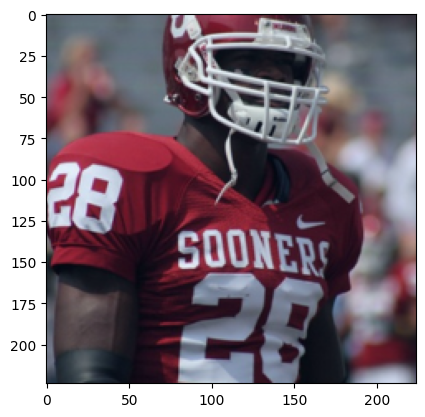

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using: ",device)

i = 0
for images, captions, lengths in test_loader:  # 遍历数据加载器中的每个批次
    i = i + 1
    if i < 3:
        continue
    images = images.to(device)  # 将图像数据移动到指定的设备上
    captions = captions.to(device)  # 将文本描述数据也移动到指定的设备上
    print(images.shape,captions.shape)
    # 准备图像数据用于显示
    image = images[0].cpu().permute(1, 2, 0).numpy()  # 将图像数据移动到CPU并调整维度以便用matplotlib显示
    # 如果图像数据是浮点数，确保它们在 [0, 1] 范围内
    if image.dtype == np.float32 or image.dtype == np.float64:
        if image.min() < 0 or image.max() > 1:
            image = (image - image.min()) / (image.max() - image.min())  # 归一化到 [0, 1]
    # 如果图像数据是整数，确保它们在 [0, 255] 范围内
    elif image.dtype == np.uint8:
        image = np.clip(image, 0, 255)
    # plt.imshow(image)
    image0 = image
    image = images[1].cpu().permute(1, 2, 0).numpy()  # 将图像数据移动到CPU并调整维度以便用matplotlib显示
    # 如果图像数据是浮点数，确保它们在 [0, 1] 范围内
    if image.dtype == np.float32 or image.dtype == np.float64:
        if image.min() < 0 or image.max() > 1:
            image = (image - image.min()) / (image.max() - image.min())  # 归一化到 [0, 1]
    # 如果图像数据是整数，确保它们在 [0, 255] 范围内
    elif image.dtype == np.uint8:
        image = np.clip(image, 0, 255)
    plt.imshow(image0)
    print([vocab_idx2word[idx.item()] for idx in captions[0] if idx.item()!=0])
    print([vocab_idx2word[idx.item()] for idx in captions[1] if idx.item()!=0])
    print([vocab_idx2word[idx.item()] for idx in captions[2] if idx.item()!=0])
    print([vocab_idx2word[idx.item()] for idx in captions[3] if idx.item()!=0])
    print([vocab_idx2word[idx.item()] for idx in captions[4] if idx.item()!=0])
    break

In [14]:
learning_rate = 3e-4

# 初始化优化器
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
from torch.optim.lr_scheduler import LambdaLR,StepLR,ExponentialLR

# 定义优化器，使用Adam优化器
optimizer = torch.optim.Adam(model.parameters())

# 定义学习率调整策略
def adjust_learning_rate(optimizer, epoch):
    """
    调整学习率。

    参数:
        optimizer (Optimizer): 优化器。
        epoch (int): 当前的epoch数。
    """
    if epoch<=6:
        base_lr = min(epoch * 1e-4, 3e-4)  # 计算基础学习率
        for param_group in optimizer.param_groups:
            param_group['lr'] = base_lr
            
    # 如果当前epoch数大于6并且可以整除3，则将学习率衰减为原来的一半
    elif epoch > 6 and (epoch - 6) % 3 == 0:
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5

# 定义学习率衰减策略
lr_schedule = StepLR(optimizer, step_size=3, gamma=0.5)

#lr_schedule = LambdaLR(optimizer, lr_lambda=lambda epoch: 1/(epoch+1))

#lr_schedule = ExponentialLR(optimizer, gamma=0.5)

In [16]:
#helper function to save the model
def save_model(model,num_epochs):
    model_state = {
        'num_epochs':num_epochs,
        'embed_size':embed_size,
        'vocab_size':vocab_size,
        'num_layers':num_layers,
        'state_dict':model.state_dict()
    }

    torch.save(model_state,'/kaggle/working/baseline.pth')

In [17]:
num_epochs = 6  # 训练的轮数
train_loss_list,val_loss_list,best_model = train(model, train_loader, val_loader, optimizer, True, criterion, num_epochs, device)

Epoch [1/6]: 100%|██████████| 3000/3000 [09:49<00:00,  5.09it/s, loss=3.87]


Train average loss: 4.457129001617432


Epoch [1/6]: 100%|██████████| 500/500 [01:06<00:00,  7.53it/s, loss=4.01]


Val average loss: 4.109854698181152


Epoch [2/6]: 100%|██████████| 3000/3000 [09:42<00:00,  5.15it/s, loss=3.45]


Train average loss: 3.9089715480804443


Epoch [2/6]: 100%|██████████| 500/500 [01:02<00:00,  8.03it/s, loss=3.97]


Val average loss: 3.819307565689087


Epoch [3/6]: 100%|██████████| 3000/3000 [09:44<00:00,  5.14it/s, loss=3.48]


Train average loss: 3.63405442237854


Epoch [3/6]: 100%|██████████| 500/500 [01:02<00:00,  8.03it/s, loss=3.72]


Val average loss: 3.672746181488037


Epoch [4/6]: 100%|██████████| 3000/3000 [09:44<00:00,  5.13it/s, loss=3.96]


Train average loss: 3.3947994709014893


Epoch [4/6]: 100%|██████████| 500/500 [01:02<00:00,  8.03it/s, loss=3.66]


Val average loss: 3.6126341819763184


Epoch [5/6]: 100%|██████████| 3000/3000 [09:43<00:00,  5.14it/s, loss=3.14]


Train average loss: 3.18751859664917


Epoch [5/6]: 100%|██████████| 500/500 [01:02<00:00,  8.02it/s, loss=3.46]


Val average loss: 3.5898802280426025


Epoch [6/6]: 100%|██████████| 3000/3000 [09:41<00:00,  5.16it/s, loss=3.16]


Train average loss: 2.973809003829956


Epoch [6/6]: 100%|██████████| 500/500 [01:01<00:00,  8.10it/s, loss=3.49]


Val average loss: 3.6236445903778076


In [18]:
save_model(best_model, num_epochs)

In [19]:
train_loss_list,val_loss_list

([4.457129001617432,
  3.9089715480804443,
  3.63405442237854,
  3.3947994709014893,
  3.18751859664917,
  2.973809003829956],
 [4.109854698181152,
  3.819307565689087,
  3.672746181488037,
  3.6126341819763184,
  3.5898802280426025,
  3.6236445903778076])

# test

In [27]:
test_model = model

Generated caption: a brown brown brown white brown white is running the


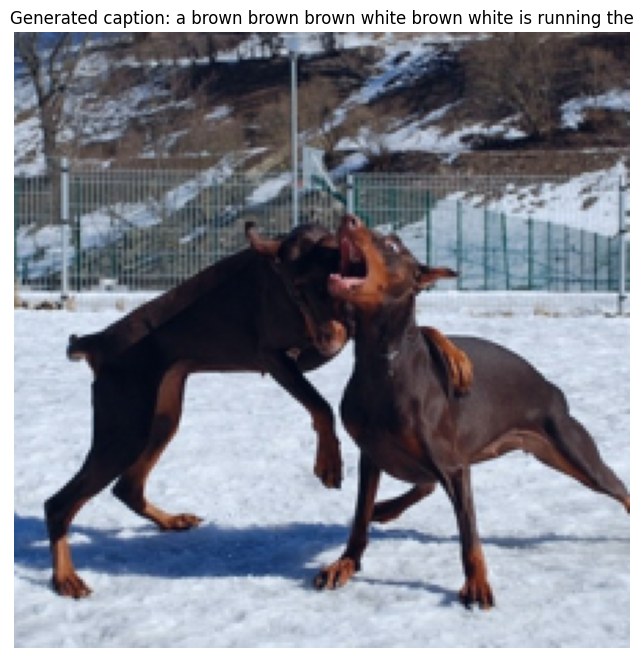

Generated caption: a people a and <unk> in water the


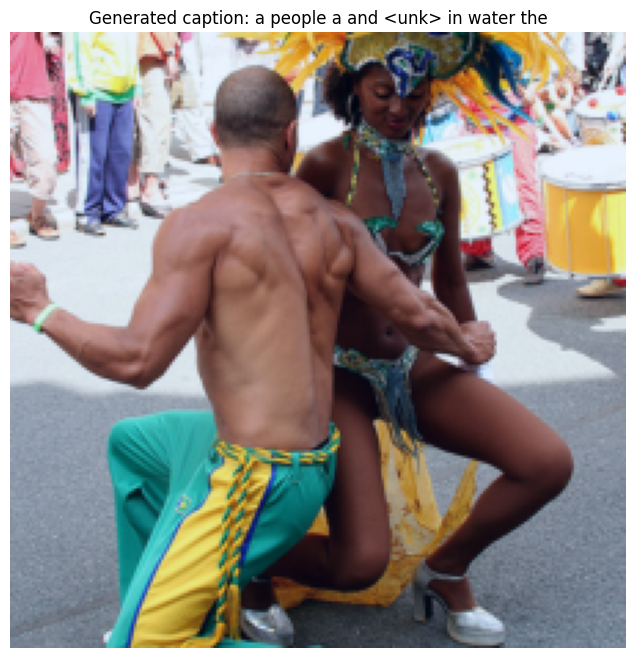

Generated caption: a football player a is to the


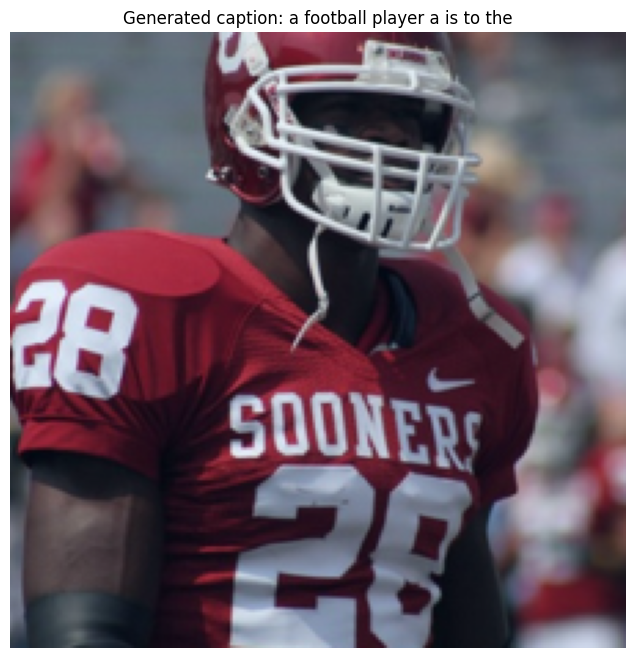

In [28]:
import matplotlib.pyplot as plt
import numpy as np  # 确保导入numpy库

def generate_and_display_captions(model, data_loader, vocab, device):
    """
    为数据加载器中的图像生成描述并显示。

    参数:
        model: 训练好的图像描述模型。
        data_loader: 数据加载器，包含要生成描述的图像。
        vocab: 词汇表，一个从索引到单词的映射。
        device: 设备类型，例如 'cuda' 或 'cpu'。
    """
    model.eval()  # 将模型设置为评估模式
    i = 0
    for images, _, _ in data_loader:  # 迭代数据加载器中的每个批次
        image = images[0].to(device).unsqueeze(0)  # 仅处理每个批次的第一张图像，并将其移动到指定设备
        caption = model.caption_image(image, vocab)  # 使用模型为图像生成描述
        generated_caption = ' '.join(caption[:-1])  # 将生成的描述列表连接成字符串
        print(f"Generated caption: {generated_caption}")  # 打印生成的描述
        
        # 准备图像数据用于显示
        image = image.squeeze().cpu().permute(1, 2, 0).numpy()  # 将图像数据移动到CPU并调整维度以便用matplotlib显示
        
        # 如果图像数据是浮点数，确保它们在 [0, 1] 范围内
        if image.dtype == np.float32 or image.dtype == np.float64:
            if image.min() < 0 or image.max() > 1:
                image = (image - image.min()) / (image.max() - image.min())  # 归一化到 [0, 1]
    
        # 如果图像数据是整数，确保它们在 [0, 255] 范围内
        elif image.dtype == np.uint8:
            image = np.clip(image, 0, 255)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(image)
        plt.title(f"Generated caption: {generated_caption}")
        plt.axis('off')  # 不显示坐标轴
        plt.show()  # 显示图像和描述
        i += 1
        if i == 3:  # 仅显示前三张图像及其描述
            break


In [ ]:
batch_size15 = 15
train_loader15, val_loader15, test_loader15 = make_train_val(
    f"/kaggle/input/myflickr8k",f"/kaggle/input/myflickr8k/vocab.json", batch_size15)

In [ ]:

# 假设vocab是一个从索引到单词的映射
vocab_idx2word = {idx: word for word, idx in vocab.items()}

# 使用测试集DataLoader
captions = generate_and_display_captions(test_model, test_loader15, vocab_idx2word, device)

In [29]:
#!pip install nltk==3.5
!pip install --upgrade nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 24.8 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: nltk
    Found existing installation: nltk 3.2.4
    Uninstalling nltk-3.2.4:
      Successfully uninstalled nltk-3.2.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
preprocessing 0.1.13 requires nltk==3.2.4, but you have nltk 3.8.1 which is incompatible.


In [30]:
!pip install rouge_metric

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 6.2 MB/s eta 0:00:00


In [ ]:
!pip install pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 20.6 MB/s eta 0:00:00


In [31]:
import nltk
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from rouge_metric import PyRouge
from pycocoevalcap.cider.cider import Cider

smooth = SmoothingFunction()

# Calculates BLEU score of predictions
def BLEU_score(gts, caps):
    # Calculating the BLEU score by comparing the predicted caption with five actual captions.
    # gts eg:   [[["this", "is", "an", "apple"]]]
    # caps eg:  [["an", "apple", "on", "this", "tree"]]
    corpus_score_1 = sentence_bleu(gts, caps, weights=(1, 0, 0, 0), smoothing_function=smooth.method1)
    corpus_score_2 = sentence_bleu(gts, caps, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth.method1)
    corpus_score_3 = sentence_bleu(gts, caps, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth.method1)
    corpus_score_4 = sentence_bleu(gts, caps, smoothing_function=smooth.method1)
    return [
        round(corpus_score_1, 5), round(corpus_score_2, 5), round(corpus_score_3, 5), round(corpus_score_4, 5)
    ]

def METEOR_score(gts, caps):
    # gts eg:   [["this", "is", "an", "apple"]]
    # caps eg:  ["an", "apple", "on", "this", "tree"]
    return meteor_score(gts, caps)

def rouge_score(gts, caps):
    # gts eg:   [[["this", "is", "an", "apple"]]]
    # caps eg:  [["an", "apple", "on", "this", "tree"]]
    rouge = PyRouge(rouge_n=(1, 2), rouge_l=True, rouge_w=False, rouge_s=False, rouge_su=False)
    score = rouge.evaluate_tokenized(caps, gts)
    return score
    
def Cider_score(gts, caps):
    cider_scorer = Cider()
    score,_ = cider_scorer.compute_score(ref_sentences, pred_sentence)
    return score

In [32]:
#show any 1
dataiter = iter(test_loader)
images,ground_truths,_ = next(dataiter)

ground_truth=[vocab_idx2word[idx.item()] for idx in ground_truths[0] if idx.item()!=0]
ground_truth = [ground_truth[1:-1]]
image = images[0].to(device).unsqueeze(0)  # 仅处理每个批次的第一张图像，并将其移动到指定设备
caption = test_model.caption_image(image, vocab_idx2word)  # 使用模型为图像生成描述
caption = caption[:-1] #去掉end符
caption

['a',
 'brown',
 'brown',
 'brown',
 'white',
 'brown',
 'white',
 'is',
 'running',
 'the']

In [33]:
dataiter = iter(test_loader)
images,ground_truths,_ = next(dataiter)

ground_truth_list = []
for i in range(5):
    ground_truth=[vocab_idx2word[idx.item()] for idx in ground_truths[i] if idx.item()!=0]
    ground_truth_list.append(ground_truth[1:-1])
ground_truth_list

[['the',
  'dogs',
  'are',
  'in',
  'the',
  'snow',
  'in',
  'front',
  'of',
  'a',
  'fence'],
 ['two', 'brown', 'dogs', 'wrestle', 'in', 'the', 'snow'],
 ['two', 'brown', 'dogs', 'playfully', 'fight', 'in', 'the', 'snow'],
 ['the', 'dogs', 'play', 'on', 'the', 'snow'],
 ['two', 'dogs', 'playing', 'in', 'the', 'snow']]

In [34]:
caption

['a',
 'brown',
 'brown',
 'brown',
 'white',
 'brown',
 'white',
 'is',
 'running',
 'the']

In [35]:
# sentence_bleu
BLEU_score(ground_truth_list, caption)

[0.27145, 0.05224, 0.03244, 0.02513]

In [36]:
METEOR_score(ground_truth_list, caption)

0.18292682926829268

In [37]:
rouge_score([ground_truth_list], [caption])

{'rouge-1': {'r': 0.75, 'p': 0.4883720930232558, 'f': 0.5915492957746479},
 'rouge-2': {'r': 0.22962962962962963,
  'p': 0.14761904761904762,
  'f': 0.17971014492753623},
 'rouge-l': {'r': 0.7214285714285714,
  'p': 0.4697674418604651,
  'f': 0.5690140845070423}}

In [38]:
def evaluate_model(model, data_loader, vocab):
    bleu = {1:[], 2:[], 3:[], 4:[]}
    meteor = []
    rouge = {1:{'r':[],'p':[],'f':[]}, 2:{'r':[],'p':[],'f':[]}, 'l':{'r':[],'p':[],'f':[]}}
    
    model.eval()  # 将模型设置为评估模式
    ref_sentences = dict()
    pred_sentence = dict()
    index = 0
    
    for idx, (images, ground_truths, _) in enumerate(iter(data_loader)):
        for i in range(0,images.shape[0],5):
            ground_truth_list = []
            ground_truth_str = []
            for j in range(5):
                ground_truth=[vocab_idx2word[idx.item()] for idx in ground_truths[i+j] if idx.item()!=0]
                ground_truth_list.append(ground_truth[1:-1])
                ground_truth_str.append(' '.join(ground_truth[1:-1]))
                
            image = images[i].to(device).unsqueeze(0)  # 仅处理每个批次的第一张图像，并将其移动到指定设备
            caption = model.caption_image(image, vocab)  # 使用模型为图像生成描述
            caption = caption[:-1] #去掉end符
            
            ref_sentences[index] = ground_truth_str
            pred_sentence[index] = [' '.join(caption)]
            index += 1
        
            score = BLEU_score(ground_truth_list, caption)
            bleu[1].append(score[0])
            bleu[2].append(score[1])
            bleu[3].append(score[2])
            bleu[4].append(score[3])
            
            score = METEOR_score(ground_truth_list, caption)
            meteor.append(score)
            
            score = rouge_score([ground_truth_list], [caption])
            rouge[1]['r'].append(score['rouge-1']['r'])
            rouge[1]['p'].append(score['rouge-1']['p'])
            rouge[1]['f'].append(score['rouge-1']['f'])
            
            rouge[2]['r'].append(score['rouge-2']['r'])
            rouge[2]['p'].append(score['rouge-2']['p'])
            rouge[2]['f'].append(score['rouge-2']['f'])
            
            rouge['l']['r'].append(score['rouge-l']['r'])
            rouge['l']['p'].append(score['rouge-l']['p'])
            rouge['l']['f'].append(score['rouge-l']['f'])
            
    return bleu, meteor, rouge, Cider_score(ref_sentences, pred_sentence), ref_sentences, pred_sentence

In [39]:
# average score
bleu, meteor, rouge = evaluate_model(test_model, test_loader, vocab_idx2word)

In [40]:
bleu_1_mean = np.mean(np.array(bleu[1]))
bleu_2_mean = np.mean(np.array(bleu[2]))
bleu_3_mean = np.mean(np.array(bleu[3]))
bleu_4_mean = np.mean(np.array(bleu[4]))
bleu_1_mean,bleu_2_mean,bleu_3_mean,bleu_4_mean

(0.53017906, 0.19109664999999998, 0.08599432, 0.056137190000000003)

In [41]:
meteor_mean = np.mean(np.array(meteor))
meteor_mean

0.23268125209787482

In [42]:
rouge_1_r_mean = np.mean(np.array(rouge[1]['r']))
rouge_1_p_mean = np.mean(np.array(rouge[1]['p']))
rouge_1_f_mean = np.mean(np.array(rouge[1]['f']))
rouge_1_r_mean,rouge_1_p_mean,rouge_1_f_mean

(0.4238579418965549, 0.738231156237707, 0.5185274513671086)

In [43]:
rouge_2_r_mean = np.mean(np.array(rouge[2]['r']))
rouge_2_p_mean = np.mean(np.array(rouge[2]['p']))
rouge_2_f_mean = np.mean(np.array(rouge[2]['f']))
rouge_2_r_mean,rouge_2_p_mean,rouge_2_f_mean

(0.1749104339632503, 0.31599786945100106, 0.21627143355033213)

In [44]:
rouge_l_r_mean = np.mean(np.array(rouge['l']['r']))
rouge_l_p_mean = np.mean(np.array(rouge['l']['p']))
rouge_l_f_mean = np.mean(np.array(rouge['l']['f']))
rouge_l_r_mean,rouge_l_p_mean,rouge_l_f_mean

(0.41546788591561606, 0.7252415297678567, 0.508729077559811)